In [104]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [105]:
#Returns the time vs. x and time vs. y data from the pixel_hits. The ATAR is made up of sheets that contain alternating horizontal or vertical strips with npixels_per_plane.
#If npixels_per_plane were 100, for instance, 100036 would represent plate 1, 36 / 100 in x, 100161 would represent plate 2, 61 / 100 in y, etc. The output for each of 
#x and y is an n x 2 matrix, where the first column contains the times corresponding to the coordinate values in the second column.
#Also extract the z (plane #) vs. time data. The third element of the tuples contained in this list and the x and y lists will contain corresponding colors to represent
#when particles have decayed.
def get_event(tree):
    #Print an entry with no pion decay or a pion decay in flight.
    for i, e in enumerate(tree):
        if e.pion_decay == 1 and e.pion_dar == 0:
            print("Index of event in tree: " + str(i))
            tree.GetEntry(i)
            break
    #Store pixel hits for the entry printed above in which a pion didn't decay at rest.
    pixel_times_motion = tree.pixel_time
    pixel_hits_motion = tree.pixel_hits
    pixel_pdg_motion = tree.pixel_pdg
    
    #Create empty data structures for storing x vs. t, y vs. t, and z vs. t data.
    npixels_per_plane = 100
    txc_data = []
    tyc_data = []
    tzc_data = []

    #Extract x vs. t, y vs. t, and z vs. t data. Also add indexed color coding to represent different particles.
    for i in range(pixel_hits_motion.size()):
        plane = int(np.floor((pixel_hits_motion[i] - 1 - 100_000) / npixels_per_plane))

        cur_val = (pixel_hits_motion[i] - 1) % npixels_per_plane
        cur_time = pixel_times_motion[i]

        if pixel_pdg_motion[i] == 211:
            cur_color = "r"     # +Pion
        elif pixel_pdg_motion[i] == -11:
            cur_color = "b"     # Positron
        elif pixel_pdg_motion[i] == 11:
            cur_color = "g"     # Electron
        elif pixel_pdg_motion[i] == -13:
            cur_color = "y"     # +Muon
        elif pixel_pdg_motion[i] == 13:
            cur_color = "p"     # -Muon


        tzc_data.append((cur_time, plane, cur_color))

        if(plane % 2 == 0):
            txc_data.append((cur_time, cur_val, cur_color))
        else:
            tyc_data.append((cur_time, cur_val, cur_color))
    
    return (txc_data, tyc_data, tzc_data)

In [106]:
#Show some useful parameters describing our event.
def display_event(txc_data, tyc_data, tzc_data):
    print("Length of txc_data: " + str(len(txc_data)))
    print("Length of tyc_data: " + str(len(tyc_data)))
    print("Length of tzc_data: " + str(len(tzc_data)))
    print("txc_data: " + str(txc_data))

In [117]:
#For each color in a list of color labels for different particles, plot the corresponding data.
def plot_with_color_legend(data):
    for color in ["r", "b", "g", "y", "p"]:
        #Include only points of 1 color each loop. This makes it easier to configure the legend.
        curpoints = []
        curindex = 0
        for i in data:
            if i[2] == color:
                curpoints.append(i)
        
        #Only plot if the current particle decay type was present in the data.
        if len(curpoints) != 0:
            if color == "r":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Pion")
            elif color == "b":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Positron")
            elif color == "g":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Electron")
            elif color == "y":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Antimuon")
            elif color == "p":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Muon")


#Plot x vs. t, y vs. t, and z vs. t data from our event. The graphs will show the color-coding system used to represent different particles.
def plot_event(txc_data, tyc_data, tzc_data):

    plt.figure(figsize = (20, 5))

    plt.subplot(1,3,1)
    plot_with_color_legend(txc_data)
    plt.title("x vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("x (pix)")
    plt.legend()
    # plt.xlim(20.157, 20.169)

    plt.subplot(1,3,2)
    plot_with_color_legend(tyc_data)
    plt.title("y vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("y (pix)")
    # plt.xlim(20.157, 20.169)

    plt.subplot(1,3,3)
    plot_with_color_legend(tzc_data)
    plt.title("z vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("z (# of planes)")
    # plt.xlim(20.157, 20.169)

    plt.subplots_adjust(left = 0.1,
                        bottom = 0.1, 
                        right = 0.9, 
                        top = 0.9, 
                        wspace = 0.5, 
                        hspace = 0.4)

In [118]:
#Combines the functions we created above to give a visualization of the first event in which
#there is a specified condition (see above code; at the moment, first no decay / decay in flight).
def event_visualization(tree):
    xt, yt, zt = get_event(tree)
    display_event(xt, yt, zt)
    plot_event(xt, yt, zt)

Index of event in tree: 66
Length of txc_data: 4
Length of tyc_data: 3
Length of tzc_data: 7
txc_data: [(2.263816630034867, 53, 'r'), (2.266164215610736, 53, 'r'), (2.268581282363194, 53, 'r'), (2.270672736151092, 53, 'r')]


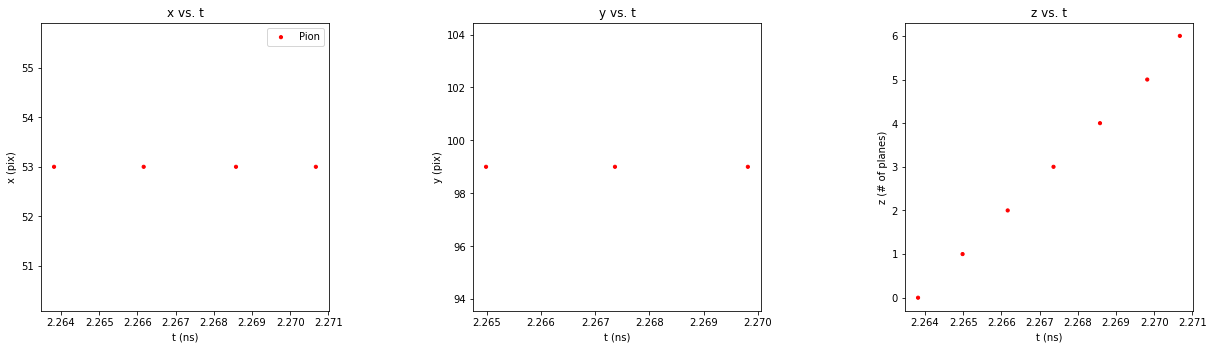

In [119]:
#Explore pion --> e data.
f = r.TFile("pienux_out_stripped.root")
t = f.Get("atar")
# print([x.GetName() for x in t.GetListOfBranches()])
# print("\n")

event_visualization(t)

Index of event in tree: 781
Length of txc_data: 32
Length of tyc_data: 32
Length of tzc_data: 64
txc_data: [(2.2180406464733355, 13, 'r'), (2.220312091676631, 13, 'r'), (2.2226385370205066, 13, 'r'), (2.2250123977636496, 13, 'r'), (2.2274542332054006, 13, 'r'), (2.2297507200996294, 13, 'y'), (2.230340780270639, 14, 'y'), (2.232645914378166, 14, 'y'), (2.233562064706862, 15, 'y'), (2.235736291593601, 15, 'y'), (2.236996288145119, 16, 'y'), (2.2388812130246047, 16, 'y'), (2.24063329660363, 17, 'y'), (2.2444491557185633, 18, 'y'), (2.248649006056382, 19, 'y'), (2.252869188454851, 20, 'y'), (2.254985289564746, 21, 'y'), (2.258548703979449, 22, 'y'), (312.8246506861661, 22, 'b'), (312.82644271341655, 24, 'b'), (312.8277125838962, 25, 'b'), (312.82981251349975, 27, 'b'), (312.8310846806117, 28, 'b'), (312.83359547575236, 30, 'b'), (312.8343836280823, 31, 'b'), (312.8366101216915, 33, 'b'), (312.8378263355075, 34, 'b'), (312.83842636427505, 35, 'b'), (312.8409930461533, 37, 'b'), (312.8415773

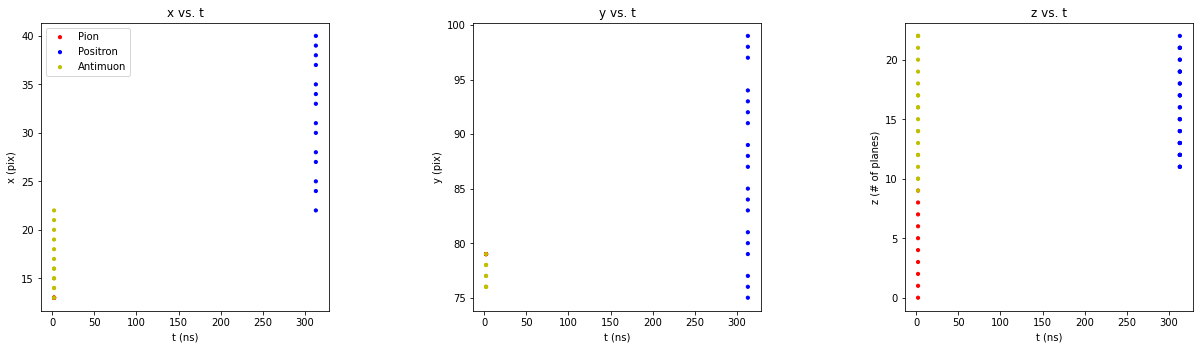

In [120]:
#Explore pion --> muon data.
f = r.TFile("pienux_out_stripped_muons.root")
t = f.Get("atar")

event_visualization(t)